# Image classification using logistic regression in PyTorch
Source: https://jovian.ai/aakashns/03-logistic-regression

## Working with Images
The dataset used is [*MNIST Handwritten Digits Database*](http://yann.lecun.com/exdb/mnist/), consisting of 28px by 28px grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents. 

Some sample images from the dataset:

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

To work with images, the torchvision library is used. It contains some utilities for working with image data, and provides helper classes to download and import popular datasets, like MNIST, automatically

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
# Download training dataset
dataset = MNIST(
    root='data/', 
    download=True,
    train=True
)

Check the dataset size

In [3]:
len(dataset)

60000

Now download the test set

In [4]:
# Download test dataset
test_dataset = MNIST(
    root='data/', 
    download=True,
    train=False
)
len(test_dataset)

10000

Consider one image

In [5]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

Each element of dataset is a pair, consisting of a 28x28px image and a label. 

The image is an object of the class `PIL.Image.Image`, part of the Python imaging library [Pillow](https://pillow.readthedocs.io/en/stable/). It is possible to visualize the images using [`matplotlib`](https://matplotlib.org/).

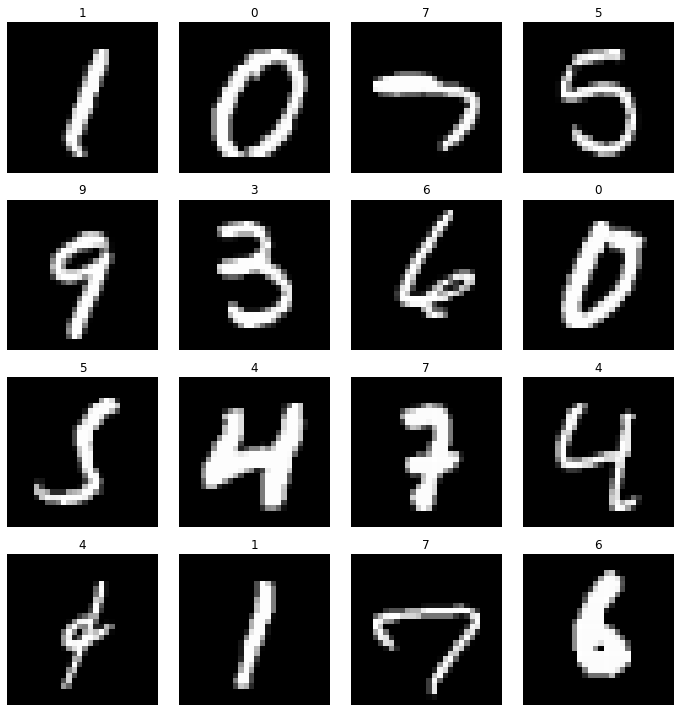

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

image, label = dataset[0]


# plt.imshow(image, cmap='gray')
# plt.title(f'label: {label}')

figure = plt.figure(figsize=(10,10))
cols, rows = 4, 4
for pos in range(1,cols*rows+1):
    id_sample = torch.randint(len(dataset),size=(1,)).item()
    image, label = dataset[id_sample]
    figure.add_subplot(rows, cols, pos)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(str(label))
    plt.tight_layout()
plt.show()

## From images to tensors
Images has to be converted to tensors so that PyTorch can work on them.

This can be done using the `transforms` module of torchvision

In [7]:
import torchvision.transforms as transforms

The trasformation is performed during the import of the image dataset

In [8]:
dataset = MNIST(
    root='/data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

In [9]:
img_tensor, label = dataset[0]
img_tensor.shape, label

(torch.Size([1, 28, 28]), 5)

The image is now converted to a 1x28x28 tensor. 
- The first dimension tracks color channels. 
- The second and third dimensions represent pixels along the height and width of the image, respectively. 

Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are three channels: red, green, and blue (RGB). 

The values in the image tensor range from 0 to 1, with `0` representing black, `1` white, and the values in between different shades of grey

## Training and Validation Datasets
The dataset is split into
1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent
2. **Validation set** - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model
3. **Test set** - used to compare different models or approaches and report the model's final accuracy

In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models results against the same collection of images. 

There's no predefined validation set, so the training set must manually split the 60,000 images into training and validation datasets. This can be done using the `random_spilt` method, part of the `utils.data` module.

In [10]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

### Dataloader
The dataset is divided into batches using the Dataloader method

In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, pin_memory=True)
validation_loader = DataLoader(val_ds, batch_size=128, pin_memory=True)

## The model

The model used to classify the images is a logistic regression. A logistic regression model is almost identical to a linear regression model: it contains weights and bias matrices, and the output is obtained using simple matrix operations (`pred = x @ w.t() + b`).

`nn.Linear` contains a built-in logistic regression model, that allows to automatically create the model and initialize the matrices.

`nn.Linear` expects each training example to be a vector, so each `1x28x28` image tensor must be **flattened** into a vector (of size 784, `(28*28)`) before being passed into the model.

The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). The predicted label for an image is the one with the highest probability.

In [12]:
import torch.nn as nn

# Logistic regression model
model = nn.Linear(
    in_features=28*28,
    out_features=10
)

The model parameter shapes are

In [13]:
print(f'weights: {model.weight.shape}')
print(f'biases: {model.bias.shape}')

weights: torch.Size([10, 784])
biases: torch.Size([10])


So there are 7850 parameters

Check what's inside each element of the dataloader

In [14]:
image_0, label_0 = list(train_loader)[0]
print(image_0.shape)
print(label_0)
print(len(label_0))

torch.Size([128, 1, 28, 28])
tensor([7, 3, 1, 8, 5, 8, 5, 1, 6, 1, 8, 1, 4, 6, 3, 9, 2, 7, 4, 6, 3, 9, 8, 6,
        4, 7, 1, 0, 1, 6, 5, 4, 9, 0, 7, 1, 1, 7, 2, 5, 0, 3, 3, 2, 2, 4, 8, 7,
        8, 4, 5, 8, 3, 7, 4, 9, 3, 4, 1, 3, 8, 2, 1, 4, 7, 9, 8, 4, 7, 1, 9, 2,
        1, 0, 3, 4, 6, 8, 2, 0, 9, 8, 1, 3, 0, 5, 8, 3, 0, 8, 3, 3, 6, 0, 8, 5,
        4, 2, 9, 7, 9, 0, 5, 3, 4, 1, 4, 3, 7, 9, 9, 4, 0, 0, 5, 4, 1, 7, 0, 0,
        1, 2, 0, 6, 6, 5, 0, 5])
128


So, each element of dataloader is a tuple of
- a tensor of 4 dimensions:
    - each element of the first dimension is a single image tensor (its dimension is 128 because there are 128 images in each batch)
    - the other dimensions are for the color channel, the height, and the width (1, 28, 28)
- a tensor containing the list of the image labels (one for each image tensor in the batch, so 128)

The image tensors should be reshaped, such that each of them becomes a vector. In this way, each element (i.e., batch) of the dataloader becomes a matrix having the batch length as number of rows (128) and image $\text{height}*\text{width}$ as number of columns (784). To reshape the tensor the `.reshape()` method can be used.

In [15]:
image_0.reshape(-1,28*28).shape

torch.Size([128, 784])

### Model and reshaping as a class
Instead of manually performing the reshaping, it can be inserted in class together with the model using the `nn.Module` as a base. 

The `nn.Module` is a blueprint for PyTorch modules:
- in the `__init__()` method the model is instantiated (and weights and biases are inizialised)
- in the `forward()` method the operations on input data are implemented (included the linear model); it is invoked a batch of inputs is passed to the model

So, in this case, the class is the following

In [16]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(28*28, 10)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 28*28)
        out = self.linear(xb)
        return out
    
model = MnistModel()

The model can be inspected using 

In [17]:
print(model.linear)
print()
print(list(model.linear.parameters()))

Linear(in_features=784, out_features=10, bias=True)

[Parameter containing:
tensor([[-0.0335, -0.0063, -0.0280,  ...,  0.0251, -0.0103, -0.0348],
        [ 0.0282,  0.0074, -0.0103,  ...,  0.0317,  0.0030, -0.0130],
        [-0.0330, -0.0238,  0.0281,  ..., -0.0098, -0.0048, -0.0218],
        ...,
        [-0.0084,  0.0114, -0.0182,  ..., -0.0285,  0.0049,  0.0129],
        [-0.0230, -0.0123, -0.0342,  ..., -0.0223, -0.0291, -0.0008],
        [-0.0187, -0.0146,  0.0206,  ...,  0.0148, -0.0258,  0.0097]],
       requires_grad=True), Parameter containing:
tensor([ 0.0321,  0.0054, -0.0116,  0.0171,  0.0030, -0.0345, -0.0240,  0.0209,
         0.0312,  0.0041], requires_grad=True)]


## Model output
The output is a vector of length 10, one element for each possible category. However, the output should be trasformed in a vector of probabilities, so that each element of the vector represents the probability that the image belongs to that category.

To convert the output rows into probabilities the **softmax function** is used

$$\sigma(z_{j})=\frac{e^{z_{j}}}{\sum_{k=1}^{K}{e^{z_{j}}}}$$

Where $z_{j}$ is the input value for class $j$.

The softmax function is implemented in PyTorch in the `torch.nn.functional` module

In [18]:
from torch.nn.functional import softmax

Consider a single output of the model

In [19]:
output_0 = model(image_0)

output_0.shape

torch.Size([128, 10])

It is possible to pass one of the rows of the output tensor (i.e., the vector containing the output values representing the "probability" of an image of belonging to each class) to the `softmax` function to transform it into an actual vector of probabilities.

The `softmax` function has a `dim` parameter, where the user has to inserted the tensor dimension on which the function has to be applied

See https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html

In [20]:
# Apply softmax for each output row
output_0_prob = softmax(output_0[:2], dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", output_0_prob.data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(output_0_prob).item())

Sample probabilities:
 tensor([[0.1115, 0.1006, 0.1188, 0.1051, 0.1090, 0.0924, 0.0804, 0.0792, 0.0771,
         0.1260],
        [0.0923, 0.0944, 0.1313, 0.1199, 0.0895, 0.0677, 0.0774, 0.1522, 0.0771,
         0.0981]])
Sum:  1.9999998807907104


To find the predicted label (i.e., the label with the highest probability) the `torch.max()` function can be used

This function returns a namedtuple (values, indices) where values is the maximum value of each row of the input tensor in the given dimension dim. And indices is the index location of each maximum value found (argmax).

See https://pytorch.org/docs/stable/generated/torch.max.html

In [21]:
max_probs, preds = torch.max(output_0_prob, dim=1)
print(preds)
print(max_probs)

tensor([9, 7])
tensor([0.1260, 0.1522], grad_fn=<MaxBackward0>)


## Evaluation Metric and Loss Function
To evaluated the results of a classification the accuracy metric can be used. The accuracy can be implemented as follows

In [22]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(torch.eq(preds,labels)).item() / len(preds))

So, in the previous example

In [23]:
image_0, label_0 = list(train_loader)[0]
output_0 = model(image_0)

print(output_0.shape)
print(label_0.shape)

accuracy(output_0, label_0)

torch.Size([128, 10])
torch.Size([128])


tensor(0.0625)

Accuracy can't be used as a loss function for optimizing to model using gradient descent for the following reasons:

1. It's not a differentiable function. `torch.max` and `==` are both non-continuous and non-differentiable operations

2. It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements.

For these reasons, accuracy is used as an **evaluation metric** for classification, but not as a loss function. A commonly used loss function for classification problems is the **cross-entropy**, which has the following formula:

$$H(\hat{p},y)=-\sum_{j}{y_{j}\log{\hat{p}_{j}}}$$

Where 
- $\hat{p}$ is the vector of the predicted probabilities for each label for an observation
- $y$ is the vector of the true labels (one-hot encoded, so its 1 only in correspondence of the correct label for that observation)

So, considering one single sample (observation) whose true label is 3 and whose computed output is $\hat{p}=[0.1,0.2,0.7]$ (given that the possible classes are just 3)
$$\hat{p}=[0.1,0.2,0.7]$$
$$y=[0,0,1]$$
In this case the cross-entropy loss is
$$H(\hat{p},y)=-(y_1*\log{p_1}+y_2*\log{p_2}+y_3*\log{p_3})$$
$$=-(0*\log{0.1}+0*\log{0.2}+1*\log{0.7})$$
$$=-\log{0.7}=-(-0.357)=0.357$$

Finally, the cross-entropy loss for the whole batch is computed as the average cross-entropy loss of the observations.

*All in all, the cross-entropy loss computed on a batch is the sum of the predicted log-probabilities of the correct labels across all the observations.*

Unlike accuracy, cross-entropy is a continuous and differentiable function. It also provides useful feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). These two factors make cross-entropy a better choice for the loss function.

PyTorch provides an efficient and tensor-friendly implementation of cross-entropy as part of the `torch.nn.functional` package. Moreover, it also performs softmax internally, so the model outputs can be passed directly without converting them into probabilities.

In [24]:
from torch.nn.functional import cross_entropy

#### (Manually implemented cross-entrompy loss for binary classification)
Source: https://machinelearningmastery.com/cross-entropy-for-machine-learning/

In [25]:
# calculate cross entropy for classification problem
from math import log
from numpy import mean

# calculate cross entropy
def cross_entropy_manual(p, q):
    return -sum([p[i]*log(q[i]) for i in range(len(p))])
 
# define classification data
p = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
q = [0.8, 0.9, 0.9, 0.6, 0.8, 0.1, 0.4, 0.2, 0.1, 0.3]

# calculate cross entropy for each example
results = list()
for i in range(len(p)):
    
    # create the distribution for each event {0, 1}
    expected = [1.0 - p[i], p[i]]
    predicted = [1.0 - q[i], q[i]]
    
    # calculate cross entropy for the two events
    ce = cross_entropy_manual(expected, predicted)
    print(f'expected: {expected}\tpredicted: {predicted}\t[y={p[i]:.1f}, yhat={q[i]:.1f}] ce: {ce:.3f} nats')
    
    # print(f'[y={p[i]:.1f}, yhat={q[i]:.1f}] ce: {ce:.3f} nats')
    results.append(ce)

# calculate the average cross entropy
mean_ce = mean(results)
print(f'Average Cross Entropy: {mean_ce:.3f} nats')

expected: [0.0, 1]	predicted: [0.19999999999999996, 0.8]	[y=1.0, yhat=0.8] ce: 0.223 nats
expected: [0.0, 1]	predicted: [0.09999999999999998, 0.9]	[y=1.0, yhat=0.9] ce: 0.105 nats
expected: [0.0, 1]	predicted: [0.09999999999999998, 0.9]	[y=1.0, yhat=0.9] ce: 0.105 nats
expected: [0.0, 1]	predicted: [0.4, 0.6]	[y=1.0, yhat=0.6] ce: 0.511 nats
expected: [0.0, 1]	predicted: [0.19999999999999996, 0.8]	[y=1.0, yhat=0.8] ce: 0.223 nats
expected: [1.0, 0]	predicted: [0.9, 0.1]	[y=0.0, yhat=0.1] ce: 0.105 nats
expected: [1.0, 0]	predicted: [0.6, 0.4]	[y=0.0, yhat=0.4] ce: 0.511 nats
expected: [1.0, 0]	predicted: [0.8, 0.2]	[y=0.0, yhat=0.2] ce: 0.223 nats
expected: [1.0, 0]	predicted: [0.9, 0.1]	[y=0.0, yhat=0.1] ce: 0.105 nats
expected: [1.0, 0]	predicted: [0.7, 0.3]	[y=0.0, yhat=0.3] ce: 0.357 nats
Average Cross Entropy: 0.247 nats


## Training the model

Having defined data loaders, model, loss function and optimizer, the model can be trained. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch.

The pseudocode is:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

Some parts of the training loop are specific the specific problem (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any problem. 

The problem-independent parts are in included within a function called `fit`, which is used to train the model. The problem-specific parts are implemented by adding new methods to the `nn.Module` class.

Starting from `nn.Module`

In [54]:
torch_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MnistModel(nn.Module):

    # model definition and parameter inizialization
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(
            28*28, 10
            # , device=torch_device
        )
    
    # forward method defined as 2 steps
    def forward(self, xb):
        # xb = xb.reshape(-1, 784)    # reshaping in the form of a vector for each image tensor
        xb = self.flatten(xb)       # alternative to reshaping
        out = self.linear(xb)       # pass through the linear model
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        images = images.to(torch_device)
        labels = labels.to(torch_device)
        out = self(images)                  # Generate predictions
        loss = cross_entropy(out, labels)   # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        images = images.to(torch_device)
        labels = labels.to(torch_device)
        out = self(images)                      # Generate predictions
        loss = cross_entropy(out, labels)       # Calculate loss
        acc = accuracy(out, labels)             # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel().to(device=torch_device)

print(model)

MnistModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


To evaluate the model a function is created

In [50]:
def evaluate(model, val_loader):

    # cross-entropy loss and accuracy are computed for each batch in the validation dataloader
    outputs = [model.validation_step(batch) for batch in val_loader]

    # the overall cross-entropy loss and accuracy of the epoch are returned
    return model.validation_epoch_end(outputs)

Finally, the `fit` function is defined

In [55]:
def fit(epochs, learning_rate, model, train_loader, val_loader, opt_func=torch.optim.SGD):

    # definition of the optimizer
    optimizer = opt_func(model.parameters(), learning_rate)
    
    # definition of history list to record the results
    history = [] 
    
    # training and validation steps for each epoch
    for epoch in range(epochs):
        
        # training step for each batch
        for batch in train_loader:

            # loss computation using the loss method of the model class
            loss = model.training_step(batch)

            # gradient computation
            loss.backward()

            # update of weights and biases using the optimizer
            optimizer.step()

            # reset of the gradients
            optimizer.zero_grad()
        
        # validation step for each batch
        result = evaluate(model, val_loader)

        # show output at the end of the epoch
        model.epoch_end(epoch, result)

        # history recording
        history.append(result)

    return history

Check the initial loss and accuracy metrics for the validation set

In [56]:
result0 = evaluate(model, validation_loader)
result0

{'val_loss': 2.296464443206787, 'val_acc': 0.09384889155626297}

Run the model

In [57]:
history1 = fit(25, 0.001, model, train_loader, validation_loader)

Epoch [0], val_loss: 1.9337, val_acc: 0.6295
Epoch [1], val_loss: 1.6683, val_acc: 0.7286
Epoch [2], val_loss: 1.4706, val_acc: 0.7611
Epoch [3], val_loss: 1.3215, val_acc: 0.7812
Epoch [4], val_loss: 1.2069, val_acc: 0.7967
Epoch [5], val_loss: 1.1167, val_acc: 0.8070
Epoch [6], val_loss: 1.0443, val_acc: 0.8154
Epoch [7], val_loss: 0.9850, val_acc: 0.8223
Epoch [8], val_loss: 0.9356, val_acc: 0.8278
Epoch [9], val_loss: 0.8937, val_acc: 0.8328
Epoch [10], val_loss: 0.8579, val_acc: 0.8379
Epoch [11], val_loss: 0.8268, val_acc: 0.8409
Epoch [12], val_loss: 0.7995, val_acc: 0.8435
Epoch [13], val_loss: 0.7754, val_acc: 0.8453
Epoch [14], val_loss: 0.7540, val_acc: 0.8467
Epoch [15], val_loss: 0.7347, val_acc: 0.8487
Epoch [16], val_loss: 0.7174, val_acc: 0.8509
Epoch [17], val_loss: 0.7016, val_acc: 0.8521
Epoch [18], val_loss: 0.6872, val_acc: 0.8538
Epoch [19], val_loss: 0.6740, val_acc: 0.8554
Epoch [20], val_loss: 0.6619, val_acc: 0.8568
Epoch [21], val_loss: 0.6507, val_acc: 0.858

Visualize with a lineplot

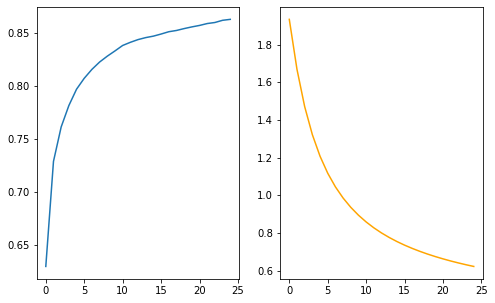

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

accuracies = [result['val_acc'] for result in history1]
losses = [result['val_loss'] for result in history1]

fig, ax = plt.subplots(1,2,figsize=(8,5))
ax[0].plot(range(len(accuracies)),accuracies)
ax[1].plot(range(len(losses)),losses,c='orange')

## Testing with individual images

In [70]:
# Define test dataset
test_dataset = MNIST(
    root='data/',
    train=False,
    transform=transforms.ToTensor()
)

Shape: torch.Size([1, 28, 28])
Label: 7


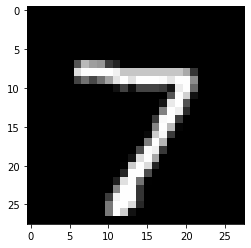

In [71]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [74]:
def predict_image(img, model):
    xb = img.unsqueeze(0).to(torch_device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

`img.unsqueeze` adds another dimension at the begining of the 1x28x28 tensor, making it a 1x1x28x28 tensor, so that the model views it as a batch containing a single image

Label: 0 , Predicted: 0


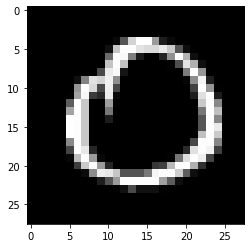

In [82]:
img, label = test_dataset[4891]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Check the overall accuracy of the model w.r.t the test set

In [83]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.5866603255271912, 'val_acc': 0.8682616949081421}